# Fetching Historical Crypto Data from Binance

In [18]:
import pandas as pd
import requests
import time

def fetch_all_crypto_data(symbol='BTCUSDT', interval='1d', start_date="2017-01-01"):
    url = "https://api.binance.com/api/v3/klines"
    all_data = []
    limit = 1000
    
    # Convert the start_date to milliseconds since epoch
    startTime = int(pd.to_datetime(start_date).timestamp() * 1000)
    
    while True:
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': limit,
            'startTime': startTime
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        # If no more data is returned, break the loop
        if not data:
            break

        all_data.extend(data)
        
        # Binance returns data sorted by open time. Get the last candle's open time.
        last_open_time = data[-1][0]
        # Set startTime for the next call (add 1 ms to avoid overlapping)
        startTime = last_open_time + 1
        
        # Optional: sleep a bit to avoid hitting rate limits
        time.sleep(0.5)
    
    # Create DataFrame with appropriate columns
    df = pd.DataFrame(all_data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "trades", "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # Convert the timestamps from ms to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    
    # Cast numeric columns to floats (timestamp columns are already converted)
    df = df.astype({
        "open": float,
        "high": float,
        "low": float,
        "close": float,
        "volume": float
    })
    
    return df

# Fetch all data from January 1, 2017 onward
crypto_df = fetch_all_crypto_data(symbol='BTCUSDT', interval='1d', start_date="2017-01-01")
print(crypto_df.head(20))
print(crypto_df.shape)


    timestamp     open     high      low    close       volume  \
0  2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377   
1  2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264   
2  2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763   
3  2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022   
4  2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060   
5  2017-08-22  4016.00  4104.82  3400.00  4040.00   966.684858   
6  2017-08-23  4040.00  4265.80  4013.89  4114.01  1001.136565   
7  2017-08-24  4147.00  4371.68  4085.01  4316.01   787.418753   
8  2017-08-25  4316.01  4453.91  4247.48  4280.68   573.612740   
9  2017-08-26  4280.71  4367.00  4212.41  4337.44   228.108068   
10 2017-08-27  4332.51  4400.00  4285.54  4310.01   350.692585   
11 2017-08-28  4310.01  4399.82  4124.54  4386.69   603.841616   
12 2017-08-29  4353.65  4625.85  4313.55  4587.48   603.545028   
13 2017-08-30  4564.52  4647.51  4416.01  4555.14   808.468771   
14 2017-08

# Visualizing Cryptocurrency Price Trends with Matplotlib

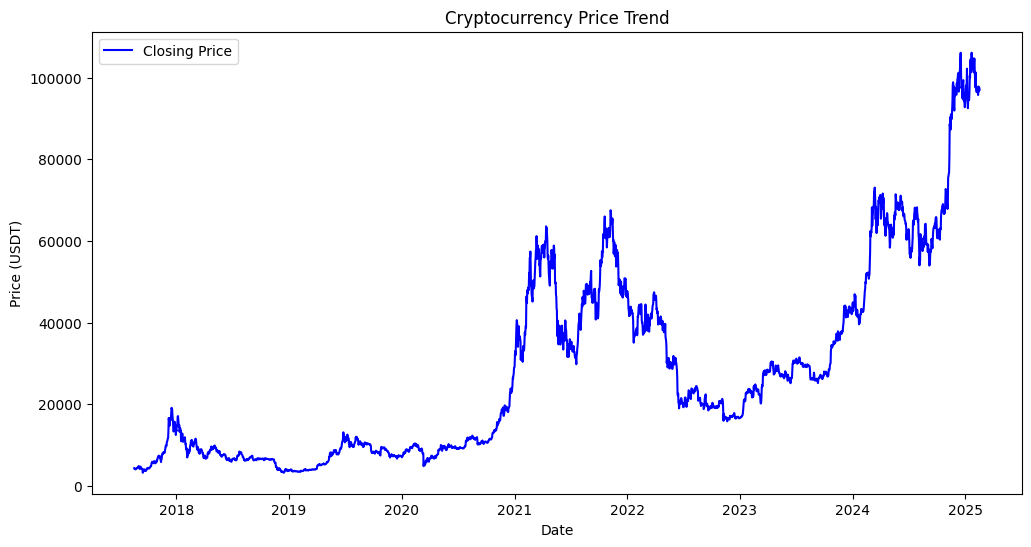

In [19]:
import matplotlib.pyplot as plt

# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(crypto_df["timestamp"], crypto_df["close"], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.title("Cryptocurrency Price Trend")
plt.legend()
plt.show()


# Data Preprocessing: Scaling the Closing Prices

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
crypto_df["close_scaled"] = scaler.fit_transform(crypto_df[["close"]])

print(crypto_df.head())


   timestamp     open     high      low    close       volume  \
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377   
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264   
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763   
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022   
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060   

               close_time quote_asset_volume  trades taker_buy_base  \
0 2017-08-17 23:59:59.999   3454770.05073206    3427   616.24854100   
1 2017-08-18 23:59:59.999   5086958.30617151    5233   972.86871000   
2 2017-08-19 23:59:59.999   1549483.73542151    2153   274.33604200   
3 2017-08-20 23:59:59.999   1930364.39032646    2321   376.79594700   
4 2017-08-21 23:59:59.999   2797231.71402728    3972   557.35610700   

    taker_buy_quote ignore  close_scaled  
0  2678216.40060401      0      0.010646  
1  4129123.31651808      0      0.008930  
2  1118001.87008735      0      0.009237  
3  1557401

# Creating Sequences for Time Series Forecasting

In [21]:
import numpy as np

def create_sequences(data, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Use only the closing price for prediction
seq_length = 20
price_data = crypto_df["close_scaled"].values
X, y = create_sequences(price_data, seq_length)

# Split data
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (2176, 20, 1), Test size: (545, 20, 1)


# Building and Training the LSTM Model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build model with L2 regularization and increased dropout
def build_model(units=50, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 1),
             kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(25, kernel_regularizer=l2(l2_reg)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Callbacks for early stopping and reducing learning rate when the validation loss plateaus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)

results = []
for units in [50, 75]:
    for dropout_rate in [0.3, 0.4]:
        print(f"Training with units={units}, dropout_rate={dropout_rate}")
        model = build_model(units=units, dropout_rate=dropout_rate)
        history = model.fit(
            X_train, y_train,
            batch_size=16,
            epochs=50,
            validation_data=(X_test, y_test),
            callbacks=[early_stop, reduce_lr],
            verbose=0  # change to 1 to see progress
        )
        final_val_loss = history.history['val_loss'][-1]
        results.append((units, dropout_rate, final_val_loss))
        print(f"Final val_loss: {final_val_loss}")

# Print the results
for config in results:
    print(f"Units: {config[0]}, Dropout: {config[1]}, Final Val Loss: {config[2]}")

# Identify the best configuration (lowest validation loss)
best_config = min(results, key=lambda x: x[2])
print(f"Best config: Units: {best_config[0]}, Dropout: {best_config[1]}, Final Val Loss: {best_config[2]}")

# Build the best model using the best hyperparameters
best_model = build_model(units=best_config[0], dropout_rate=best_config[1])


Training with units=50, dropout_rate=0.3
Final val_loss: 0.011663573794066906
Training with units=50, dropout_rate=0.4
Final val_loss: 0.01286577619612217
Training with units=75, dropout_rate=0.3
Final val_loss: 0.006004138849675655
Training with units=75, dropout_rate=0.4
Final val_loss: 0.013349580578505993
Units: 50, Dropout: 0.3, Final Val Loss: 0.011663573794066906
Units: 50, Dropout: 0.4, Final Val Loss: 0.01286577619612217
Units: 75, Dropout: 0.3, Final Val Loss: 0.006004138849675655
Units: 75, Dropout: 0.4, Final Val Loss: 0.013349580578505993
Best config: Units: 75, Dropout: 0.3, Final Val Loss: 0.006004138849675655


# Predicting Cryptocurrency Prices

18/18 [==============================] - 1s 5ms/step


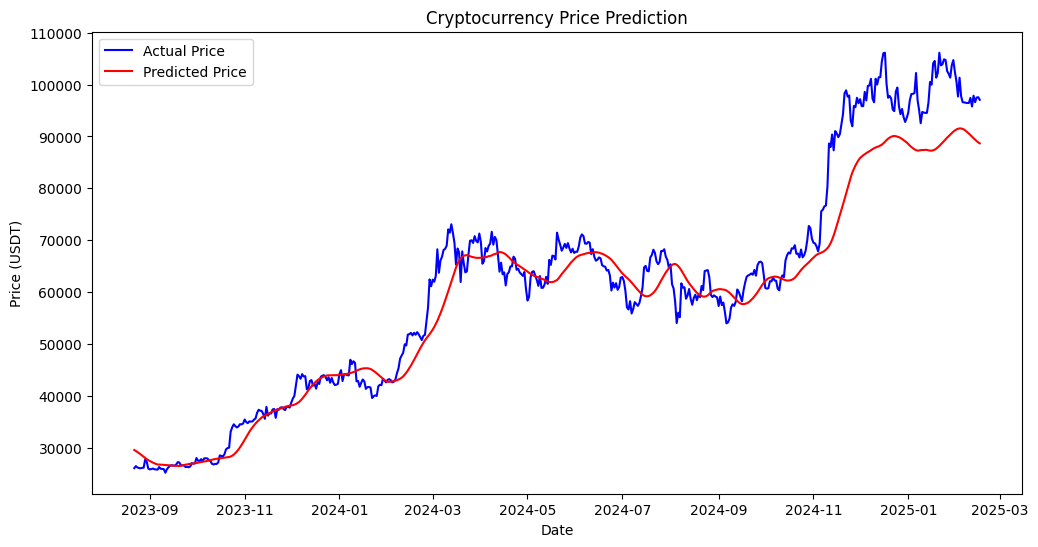

In [23]:
# Predict test set
predictions = model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

# Plot predictions vs actual prices
plt.figure(figsize=(12,6))
plt.plot(crypto_df["timestamp"][-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Price", color='blue')
plt.plot(crypto_df["timestamp"][-len(y_test):], predictions, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.title("Cryptocurrency Price Prediction")
plt.legend()
plt.show()


# Forecasting the Next Year of Crypto Prices

1/1 [==============================] - 0s 19ms/step


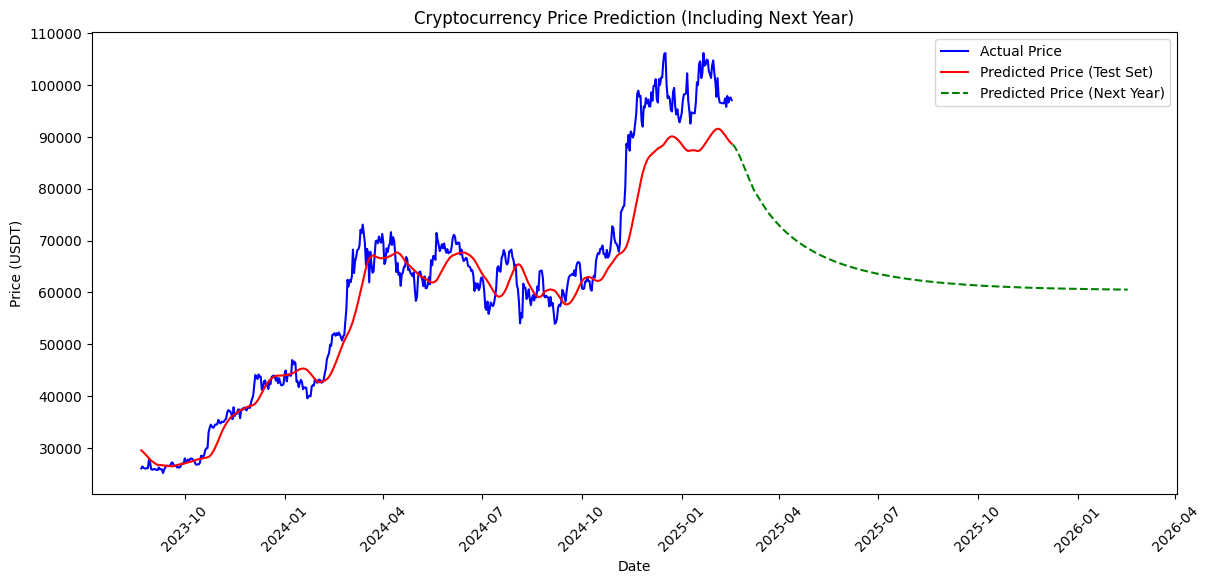

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd

# Ensure seq_length is defined, e.g.:
seq_length = 20  # or your chosen sequence length

# Number of future days to predict (1 year = 365 days)
future_days = 365

# Ensure the 'timestamp' column is in datetime format
crypto_df["timestamp"] = pd.to_datetime(crypto_df["timestamp"])

# Get the last date as a datetime object
last_date = crypto_df["timestamp"].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# Get the last sequence of prices for making future predictions
# Cast to np.float32 to ensure correct type for TensorFlow
last_sequence = crypto_df["close_scaled"].values[-seq_length:].astype(np.float32).reshape(1, seq_length, 1)

# Predict future prices iteratively for the next year
future_predictions = []
for _ in range(future_days):
    predicted_price_scaled = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
    future_predictions.append(predicted_price)
    
    # Update last_sequence: drop the first value and append the new prediction
    new_sequence = np.append(last_sequence[0, 1:, 0], predicted_price_scaled[0, 0]).astype(np.float32)
    last_sequence = new_sequence.reshape(1, seq_length, 1)

# Assuming predictions (for test set) and y_test are defined from previous steps
# Ensure that y_test is reshaped appropriately
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual prices (test set), test predictions, and future predictions
plt.figure(figsize=(14,6))

# Plot actual prices from the test set
plt.plot(crypto_df["timestamp"][-len(y_test):], y_test_actual, label="Actual Price", color='blue')

# Plot predicted prices for the test set (assumed to be computed earlier)
plt.plot(crypto_df["timestamp"][-len(y_test):], predictions, label="Predicted Price (Test Set)", color='red')

# Plot future predictions (dashed green line)
plt.plot(future_dates, future_predictions, label="Predicted Price (Next Year)", linestyle="dashed", color='green')

# Format the x-axis to display dates every quarter
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.title("Cryptocurrency Price Prediction (Including Next Year)")
plt.legend()
plt.show()


# Buy, Hold, or Cry? Predicting Future Crypto Prices

In [25]:
import numpy as np

def predict_future_price(future_date_str, seq_length=20):
    # Convert input date to datetime object
    future_date = pd.to_datetime(future_date_str)

    # Ensure we have enough past data for prediction
    last_sequence = crypto_df["close_scaled"].values[-seq_length:]
    last_sequence = np.array(last_sequence).reshape(1, seq_length, 1)  # Ensure proper shape

    # Predict future price
    predicted_price_scaled = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]  # Reshape before inverse scaling

    # Get last actual price
    last_actual_price = crypto_df["close"].values[-1]

    # Decision logic
    price_change = ((predicted_price - last_actual_price) / last_actual_price) * 100  # Percentage change
    if price_change > 5:
        decision = "BUY 📈 (Predicted price is significantly higher)"
    elif -5 <= price_change <= 5:
        decision = "HOLD 🤔 (Predicted price is similar to current)"
    else:
        decision = "WAIT ⏳ (Predicted price is lower)"

    # Display results
    print(f"Current Price: ${last_actual_price:.2f}")
    print(f"Predicted Price on {future_date.strftime('%Y-%m-%d')}: ${predicted_price:.2f}")
    print(f"Price Change: {price_change:.2f}%")
    print(f"Decision: {decision}")

# Example usage
predict_future_price("2025-06-01")


1/1 [==============================] - 0s 25ms/step
Current Price: $97061.58
Predicted Price on 2025-06-01: $88503.51
Price Change: -8.82%
Decision: WAIT ⏳ (Predicted price is lower)
